In [1]:
import matplotlib.pyplot as plt
import pyvista
import ufl
import numpy as np

from petsc4py import PETSc
from mpi4py import MPI

import dolfinx
from dolfinx import fem, mesh, io, plot
from dolfinx.fem import Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from ufl import (FacetNormal, FiniteElement, Identity, TestFunction, TrialFunction, VectorElement,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)


# Define temporal parameters
t = 0  # Start time
T = 2.0  # Final time
# num_steps = 1000  # Number of time steps
dt = 1e-3  # Time step size

# Define the domain
n_x = 2**7 + 1
# create 1D mesh
domain = mesh.create_interval(comm=MPI.COMM_WORLD, points=(0.0, 1.0), nx=n_x)

# Define function space (P2 element for better accuracy)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

In [21]:
def project(e, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    v = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(v, w) * dx)
    L = dolfinx.fem.form(ufl.inner(e, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setType("bcgs")
    solver.getPC().setType("bjacobi")
    solver.rtol = 1.0e-05
    solver.setOperators(A)
    solver.solve(b, target_func.vector)
    assert solver.reason > 0
    target_func.x.scatter_forward()

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()



def project_codimension(p_expression, target_func, projector, mt, mt_id, eps=1.0e-03):
    """
    Project expression defined on codimension (on a mesh-tagged subset) into given function.

    Args:
        p_expression: The (projected) expression.
        target_func: The target function.
        projector: The functor that performs the expected projection.
        mt: Meshtags
        mt_id: Meshtag id that determines the set of codimension entities.
        eps: Augmentation factor.
    """
    import numpy as np

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    ds = ufl.ds(domain=V.mesh, subdomain_data=mt, subdomain_id=mt_id)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    v = ufl.TrialFunction(V)
    ε = eps  # * ufl.FacetArea(V.mesh)
    a = dolfinx.fem.form(ufl.inner(projector(v), projector(w)) * ds + ε * ufl.inner(v, w) * ds)
    L = dolfinx.fem.form(ufl.inner(p_expression, projector(w)) * ds)

    # Get dofs not associated with mt = inactive
    dofs_mt = dolfinx.fem.locate_dofs_topological(V, V.mesh.topology.dim - 1, mt.find(mt_id))
    dofsall = np.arange(V.dofmap.index_map.size_local + V.dofmap.index_map.num_ghosts, dtype=np.int32)
    dofs_inactive = np.setdiff1d(dofsall, dofs_mt, assume_unique=True)

    # Zero-valued inactive dofs
    zero = dolfinx.fem.Function(V)
    bcs = [dolfinx.fem.dirichletbc(zero, dofs_inactive)]

    # Create operator
    pattern = dolfinx.fem.create_sparsity_pattern(a)
    pattern.insert_diagonal(dofs_inactive)
    pattern.finalize()
    A = dolfinx.cpp.la.petsc.create_matrix(V.mesh.comm, pattern)

    # Assemble linear system
    A.zeroEntries()
    dolfinx.fem.petsc.assemble_matrix_mat(A, a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setType("bcgs")
    solver.getPC().setType("bjacobi")
    solver.rtol = eps * 1.0e-02
    solver.setOperators(A)
    solver.solve(b, target_func.vector)
    assert solver.reason > 0
    target_func.x.scatter_forward()

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

    return target_func

In [22]:
# _, _, x = plot.vtk_mesh(V)
# x.shape
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain, domain.topology.dim))

In [23]:
p_mesh

UnstructuredGrid,Information
N Cells,129
N Points,130
X Bounds,"0.000e+00, 1.000e+00"
Y Bounds,"0.000e+00, 0.000e+00"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


In [24]:
# create initial condition
mu = 0.9
def initial_condition(x):
     return mu*np.sin(2*np.pi*x[0]) * (x[0] <= 0.5)

In [25]:
u_n = fem.Function(V)  # Trial function
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# create boundary condition
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [26]:
mt = dolfinx.mesh.meshtags(domain, fdim, boundary_facets, np.full_like(boundary_facets, 1))
mt_id = 1 # since we assinged 1 to all boundary facets

# Time dependent output

In [27]:
# xdmf = io.XDMFFile(domain.comm, "burgers.xdmf", "w")
# xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
# xdmf.write_function(uh, t)

# increment for Newton solver
del_u = fem.Function(V)

# Variational problem and solver

In [28]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))

In [29]:
from ufl import dx, dot, grad, inner, div, sym, nabla_grad

# Define parameters
Reynolds = 1e-2

# Advective flux of conservation law:
e0 = PETSc.ScalarType(1.0)
def flux(u):
    # Vector of dimension 1, for consistency w/ grad, div
    return 0.5*u*u*e0

# DT = Constant(dt)

# Define the variational problem
F = (dot(uh - u_n, v)/dt
    # - dot(flux(uh), v.dx(0))
    + dot(uh * uh.dx(0), v)
    + Reynolds*dot(grad(uh), grad(v))
    )*dx

# define forcing term
# f = dolfinx.fem.Constant(domain, PETSc.ScalarType(0.0))
# L = ufl.inner(f, v) * ufl.dx

In [30]:
import dolfinx.fem.petsc
import dolfinx.nls.petsc
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc

sol = []

# Define the solver
problem = fem.petsc.NonlinearProblem(F, uh, bcs=[bc])
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

# Time-stepping loop
t = 0.0
while t < T:
    t += dt

    # Solve linear problem
    solver.solve(uh)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    
    # save as array
    sol.append(uh.vector[:])
    

In [31]:
# Compute and store gradients
# gradients = []
# for u_h in solutions:


# # Function to compute projection of gradient
# def project_gradient(u, target_func):
#     # Identity projector (no modification to the gradient)
#     projector = lambda x: x 
#     project_codimension(ufl.grad(u), target_func, projector, mt, mt_id)

# Create a Function to store the gradient
grad_uh = fem.Function(V)

# # Project the gradient of uh onto grad_uh
# project_gradient(uh, grad_uh)

project(uh.dx(0), grad_uh, bcs=[bc])


In [32]:
grad_uh.vector[:].shape

(130,)

In [33]:
gradient = ufl.grad(uh)
grad_uh = fem.FunctionSpace(domain, ("Lagrange", 1))
grad_uh_expr = fem.Expression(gradient, grad_uh.element.interpolation_points())
gradients = fem.Function(grad_uh)
gradients.interpolate(grad_uh_expr)
print(gradients.vector[:].shape)

(130,)


In [34]:
# get the solution
u_sol = np.array(sol)
print(u_sol.shape)

(2001, 130)


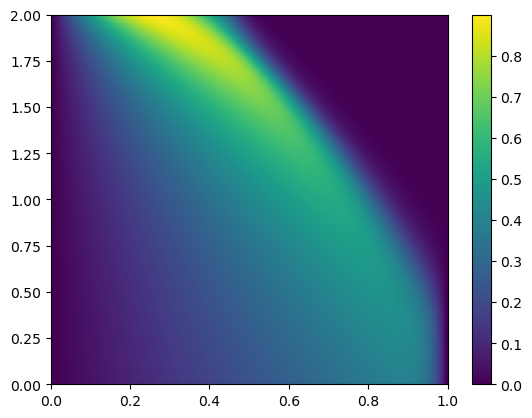

In [35]:
# plot the solution coordinates vs time
# x axis is coordinates, y axis is time
fig, ax = plt.subplots()
plt.colorbar(ax.imshow(u_sol, aspect='auto', extent=[0, 1, 0, T]))



In [36]:
np.max(u_sol)

0.8994876229838933

In [37]:
u_sol.shape

(2001, 130)

In [38]:
# # make gif of the solution using matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# line, = ax.plot(u_sol[0])

# def update(num, data, line):
#     line.set_ydata(data[num])
#     return line,

# ani = animation.FuncAnimation(fig, update, len(u_sol), fargs=(u_sol, line),
#                                 interval=25, blit=True)

# ani.save('burgers.gif', writer='imagemagick')